<a href="https://colab.research.google.com/github/alimaneef/YoloV5_E/blob/main/ManhattanProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Noise Reduction and Deskewing Functions (Preprocessing)**

In [23]:
# ************** Function to deskew the text *******************

#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [24]:
# *********** Function to remove Noise from the Image **************

def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

7


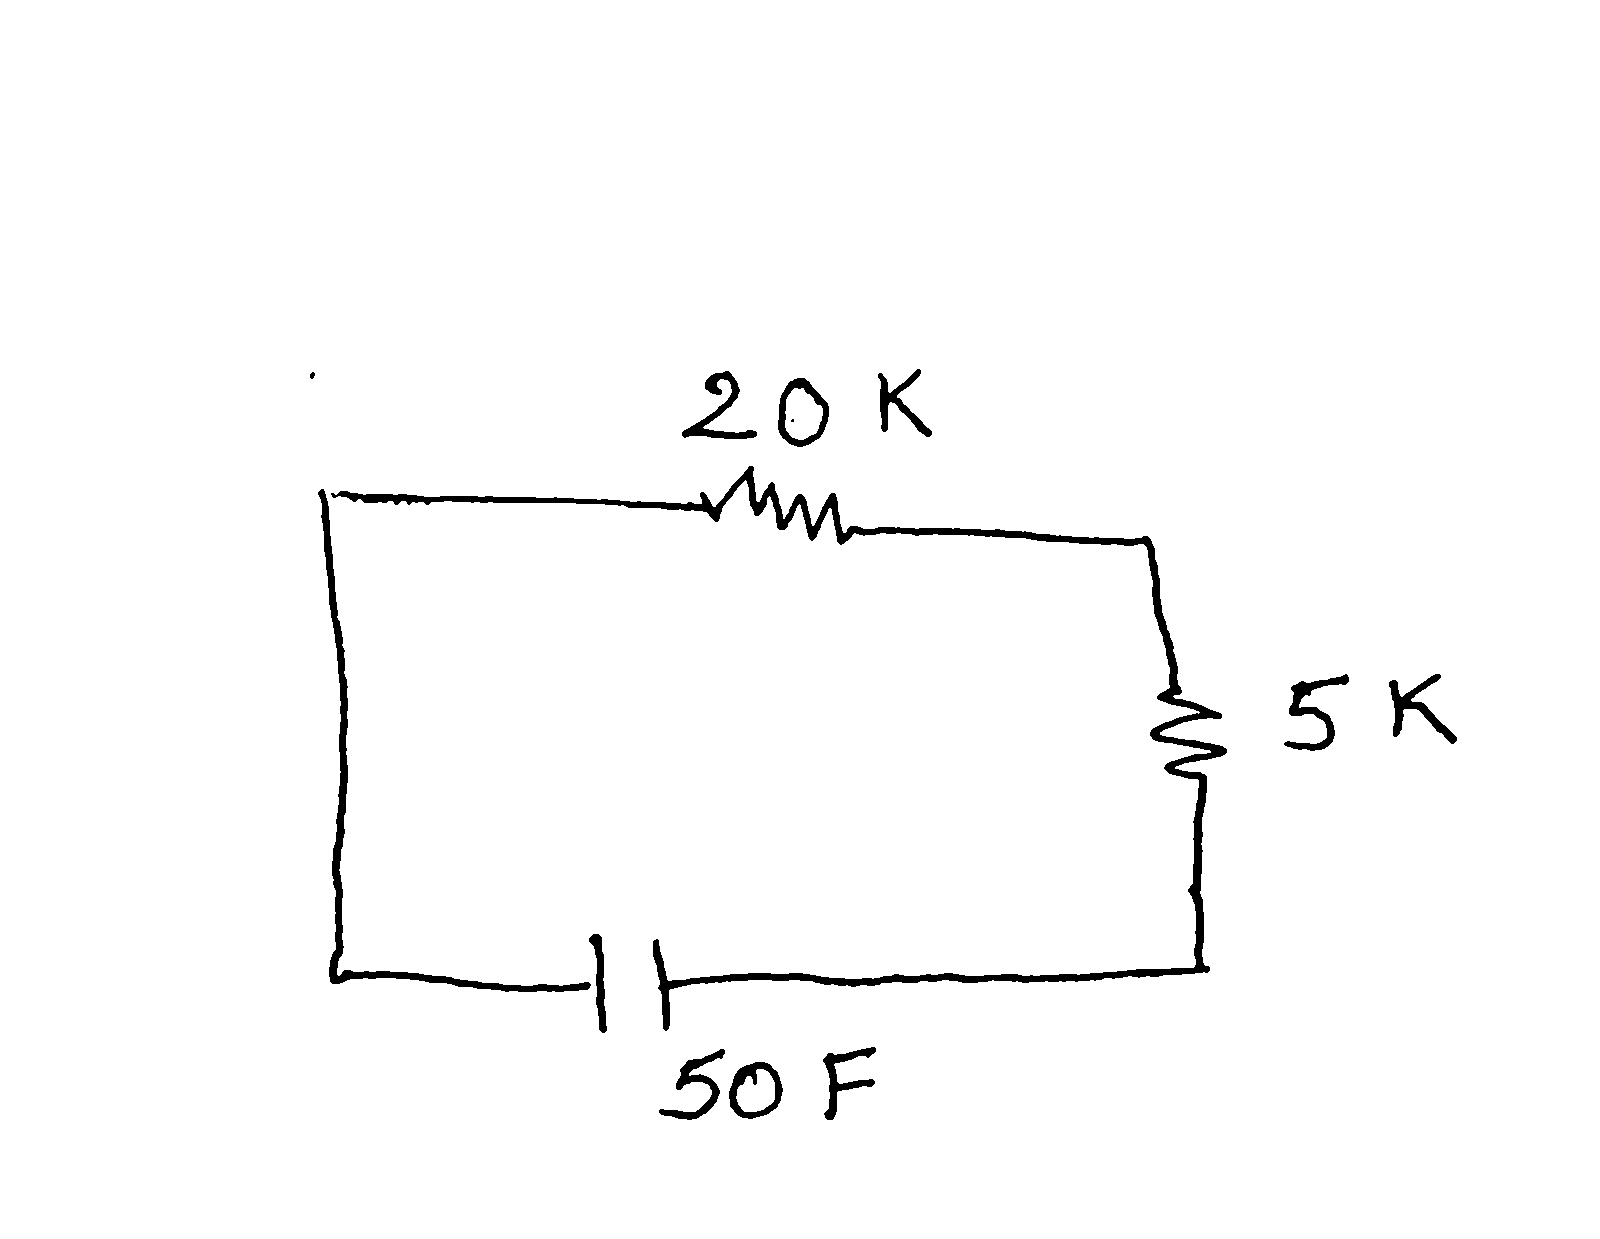

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Only for Google Colab
import matplotlib.pyplot as plt
# Load the image
image_path = '/content/test7.jpg'
img=cv2.imread(image_path)
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# ******** Converting GrayScale Image to Binary *************

ret,thresh=cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY)

# ********  Applying Blur on Image *****************
k_size=3
thresh=cv2.medianBlur(thresh,k_size)
ret,thresh=cv2.threshold(thresh,100,255,cv2.THRESH_BINARY)

# *********** Noise Removal from Image ****************
no_noise_img = noise_removal(thresh)
cv2.imwrite("noiseRemoved.jpg",no_noise_img)


# *********** Edge Detection using Canny *************
img_edge=cv2.Canny(no_noise_img,200,300)

# *********** Dilating the edges for proper visualization *************
img_edge_d=cv2.dilate(img_edge,np.ones((5,5),dtype=np.int8))

# *********** Fixes Text Rotation ***************
fixed_img=deskew(img)


# *** Printing the image ****
cv2_imshow(no_noise_img)

# **Object Detection using YOLOv5 (Roboflow API)**

loading Roboflow workspace...
loading Roboflow project...


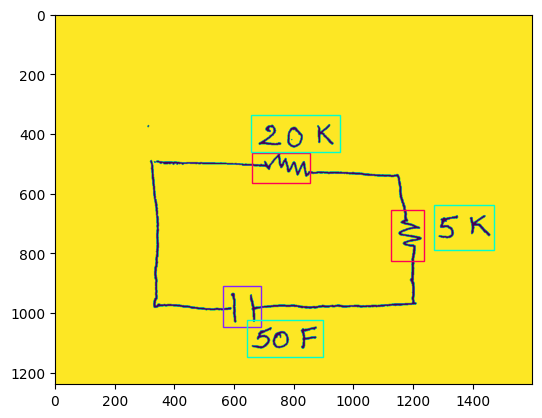

In [26]:
!pip install roboflow
import roboflow

rf = roboflow.Roboflow(api_key="s5x7SRtXClTYVdRddG1E")

project = rf.workspace().project("electronic-circuit-iysi9")
model = project.version("3").model

model.confidence = 55
model.overlap = 25

no_noise_image_path='/content/noiseRemoved.jpg'
prediction = model.predict(no_noise_image_path)

prediction.plot()


In [27]:
print(prediction)

{
  "x": 627,
  "y": 977,
  "width": 130,
  "height": 139,
  "confidence": 0.9009498953819275,
  "class": "capacitor",
  "class_id": 0,
  "detection_id": "2b56eeb0-8a3f-4fc1-bb21-847304878b42",
  "image_path": "/content/noiseRemoved.jpg",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 1182,
  "y": 740,
  "width": 110,
  "height": 172,
  "confidence": 0.8330786228179932,
  "class": "resistor",
  "class_id": 2,
  "detection_id": "f4af5ef4-e1ec-4d1c-8d3a-bb095f5b9d95",
  "image_path": "/content/noiseRemoved.jpg",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 758,
  "y": 513,
  "width": 197,
  "height": 100,
  "confidence": 0.7611206769943237,
  "class": "resistor",
  "class_id": 2,
  "detection_id": "e1a6697d-6f45-48a4-bffe-19d78047f1a0",
  "image_path": "/content/noiseRemoved.jpg",
  "prediction_type": "ObjectDetectionModel"
}

{
  "x": 1371,
  "y": 713,
  "width": 202,
  "height": 149,
  "confidence": 0.7568081617355347,
  "class": "inductor",
  "class_id": 1,
  "dete

In [28]:
# Drawing bounding boxes utilizing the results obtained using YOLOv5

from PIL import Image, ImageDraw,ImageFont
image = Image.open(image_path)

# Create a drawing context
draw = ImageDraw.Draw(image)

# font handling
fontObj=ImageFont.truetype('Humor-Sans.ttf',42,)

# YOLOv5 prediction data (bounding boxes and classes)

# Draw bounding boxes on the image
for detection in prediction:
    # Calculate the top-left and bottom-right coordinates of the bounding box
    if(detection['confidence']<0.75):
      continue
    x1 = detection["x"] - detection["width"] / 2
    y1 = detection["y"] - detection["height"] / 2
    x2 = detection["x"] + detection["width"] / 2
    y2 = detection["y"] + detection["height"] / 2

    # Draw the bounding box
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # Label the box with the class name
    draw.text((x1,y1-28),detection['class'],'green',font=fontObj)

# Save the image with drawn boxes
output_path = 'output_image_with_boxes.jpg'  # Path to save the image
image.save(output_path)

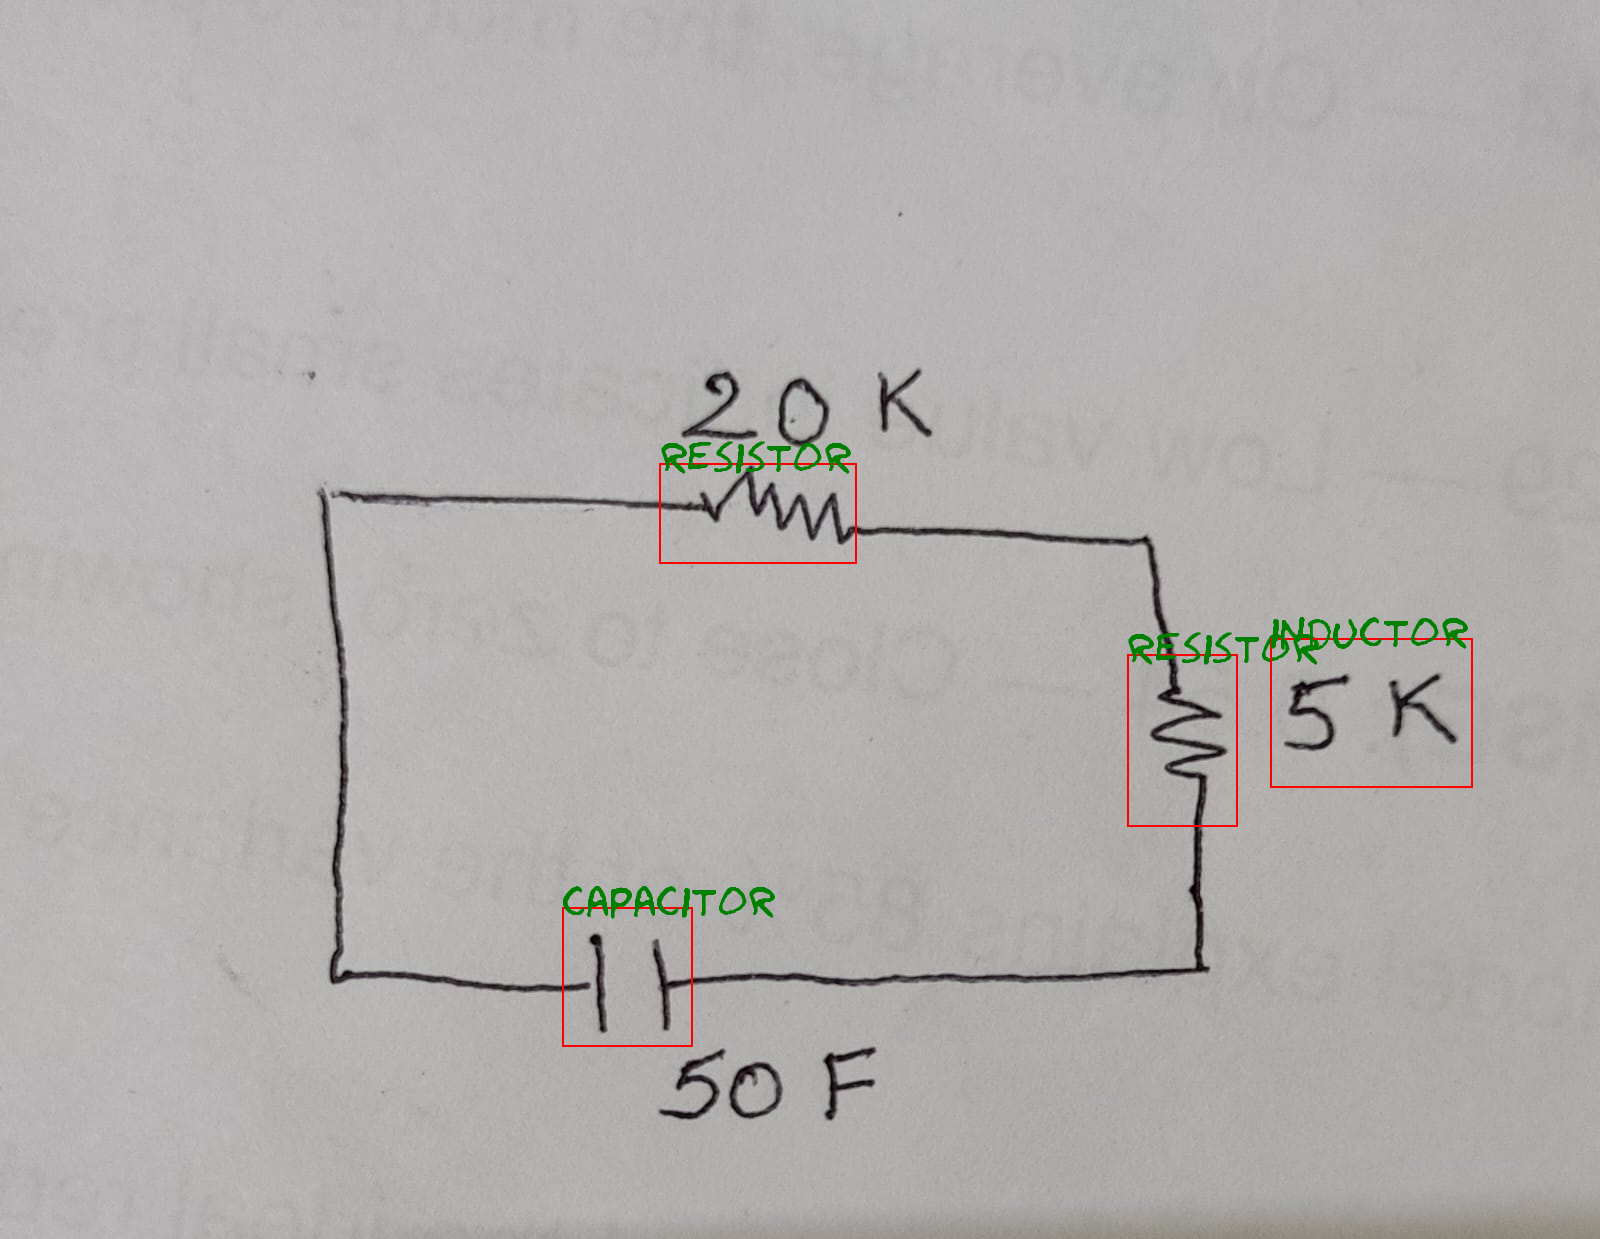

In [29]:
# Displaying the result of detected compoents in the image
image

# **Text Detection using Pytesseract**

In [30]:
# ************ Using Pytesseract ***************

# Installing Pytesseract
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install pytesseract
import pytesseract
from PIL import Image

# Finding the results
ocr_result = pytesseract.image_to_string(no_noise_img)
# print (ocr_result)

# Extracting only number from the textual string
import re
pattern = "[0-9]+.?[0-9]*"
Num_results=re.findall(pattern,ocr_result)
print(Num_results)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
['20K', '50 ']


# **Component Detection**

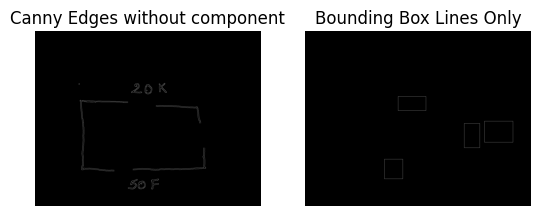

In [32]:
import cv2
import numpy as np
from PIL import Image

# Load the image using OpenCV
 # Replace with your actual image path
image = cv2.imread(no_noise_image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5,5), 1.5)
# Apply Canny edge detection
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
bounding_lines = np.zeros_like(edges)
# YOLOv5 prediction data (bounding boxes and classes)

# Remove the areas corresponding to the bounding boxes by setting them to 0 (black) in the edge-detected image
for detection in prediction:
    if(detection['confidence']<0.75):
      continue
    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(detection["x"] - detection["width"] / 2)
    y1 = int(detection["y"] - detection["height"] / 2)
    x2 = int(detection["x"] + detection["width"] / 2)
    y2 = int(detection["y"] + detection["height"] / 2)
    cv2.rectangle(bounding_lines, (x1, y1), (x2, y2), 255, thickness=1)
    # Set the region inside the bounding box to 0 (black) in the edges image
    edges[y1:y2, x1:x2] = 0

# Save and display the resulting edge-detected image
# Display the full Canny image
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges without component")
plt.axis('off')

# Display the bounding box lines only
plt.subplot(1, 2, 2)
plt.imshow(bounding_lines, cmap='gray')
plt.title("Bounding Box Lines Only")
plt.axis('off')

# Show both images side by side
plt.show()

In [33]:
binary_matrix = np.where(edges > 0, 1, 0)
rectangle_matrix = np.where(bounding_lines>0,1,0)

In [35]:
# revert binary matrix to image just for checking
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Only for Google Colab users
def getBinaryMatrix(bin):
  image_matrix = (bin * 255).astype(np.uint8)

  # Assuming binary_matrix is your 0 and 1 binary matrix
  # Step 1: Convert binary matrix to pixel values (0 and 255)


  # Step 2: Display the image using cv2_imshow (if using Google Colab)
  cv2_imshow(image_matrix)

  # Step 3: Save the image (optional)
  cv2.imwrite('reverted_image.png', image_matrix)


In [ ]:
getBinaryMatrix(rectangle_matrix)

In [ ]:
getBinaryMatrix(binary_matrix)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Only for Google Colab users

def dfs_iterative(matrix, start_x, start_y, label, threshold=1):
    stack = [(start_x, start_y)]  # Use a stack to hold cells to visit
    # Directions for 8 possible moves (up, down, left, right, and diagonals)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while stack:
        x, y = stack.pop()  # Get the last cell added to the stack

        # Check boundaries and if the cell is part of the component
        if x < 0 or x >= matrix.shape[0] or y < 0 or y >= matrix.shape[1] or matrix[x, y] != 1:
            continue

        # Mark the cell with the label
        matrix[x, y] = label

        # Add all 8 adjacent cells to the stack
        for dx, dy in directions:
            stack.append((x + dx, y + dy))

        # Check for connectivity within the threshold
        for dx in range(-threshold, threshold + 1):
            for dy in range(-threshold, threshold + 1):
                # Ensure we don't exceed matrix boundaries
                if dx == 0 and dy == 0:
                    continue  # Skip the current cell
                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < matrix.shape[0]) and (0 <= new_y < matrix.shape[1]):
                    if matrix[new_x, new_y] == 1:  # Check for connected pixels
                        stack.append((new_x, new_y))

def label_connected_components(binary_matrix, threshold=1):
    # Create a copy of the binary matrix to store labels
    labeled_matrix = binary_matrix.copy()

    # Initialize label (starting from 2 since 0 and 1 are used in the binary matrix)
    label = 2

    for i in range(labeled_matrix.shape[0]):
        for j in range(labeled_matrix.shape[1]):
            if labeled_matrix[i, j] == 1:  # Found an unvisited part of a component
                dfs_iterative(labeled_matrix, i, j, label, threshold)
                label += 1  # Increment label for the next component

    return labeled_matrix

def visualize_labels_without_compression(labeled_matrix):
    # Create a color image with the same height and width as the labeled matrix
    height, width = labeled_matrix.shape
    color_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Create a unique color map for labels
    unique_labels = np.unique(labeled_matrix)
    np.random.seed(0)  # For reproducible random colors
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3))

    # Map each label to its corresponding color
    for idx, label in enumerate(unique_labels):
        if label > 1:  # Skip background (0 and 1)
            # Create a mask for the current label
            mask = (labeled_matrix == label)
            # Set the color for the pixels in the color image
            color_image[mask] = colors[idx]

    # Return the color image
    return color_image

# Example usage

# Label the connected components with a threshold for connectivity
threshold = 10  # Adjust the threshold as necessary
labeled_matrix = label_connected_components(binary_matrix, threshold)

# Visualize the labels on the image without compression
visualized_image = visualize_labels_without_compression(labeled_matrix)

# Display the visualized labels (Google Colab)
cv2_imshow(visualized_image)
def count_labels(labeled_matrix):
    unique_labels = np.unique(labeled_matrix)
    num_labels = len(unique_labels) - 1  # Exclude background (0)
    return num_labels
# Count the number of labels
num_labels = count_labels(labeled_matrix)
print(f'Number of labels: {num_labels}')
# If running locally, use this instead to display the image:
# cv2.imshow('Labeled Components', visualized_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
image_height, image_width = image.shape[:2]

# YOLOv5 prediction data (bounding boxes and classes)

# Create a blank binary matrix (label matrix) with the same dimensions as the image
labelled_matrix_component = np.zeros((image_height, image_width), dtype=np.int32)

# Label the boundary (outline) of each bounding box in the binary matrix with unique integer values
for i,detection in enumerate(prediction):
    if(detection['confidence']<0.75):
      continue
    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(detection["x"] - detection["width"] / 2)
    y1 = int(detection["y"] - detection["height"] / 2)
    x2 = int(detection["x"] + detection["width"] / 2)
    y2 = int(detection["y"] + detection["height"] / 2)

    # Label the boundary of the bounding box with the unique label ID (outline only)
    label_id = i+1
    cv2.rectangle(labelled_matrix_component, (x1, y1), (x2, y2), label_id, thickness=10)

# Visualize the original image and the label matrix
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Show the labeled outline matrix
plt.subplot(1, 2, 2)
plt.imshow(labelled_matrix_component, cmap='tab20')
plt.title("Labeled Bounding Box Outlines")
plt.colorbar()  # Show color bar to visualize different labels
plt.axis('off')

# Display both images side by side
plt.show()

In [41]:
no_of_component_labels = count_labels(labelled_matrix_component)

In [ ]:
intersection_set = []

# Step 2: Loop through the first matrix
for i, row in enumerate(labelled_matrix_component):
    for j, value in enumerate(row):
        # Step 3: Check if the value is non-zero in both matrices
        if value != 0 and labeled_matrix[i][j] != 0:
            # Create a key-value pair as a tuple and add to the set
            intersection_set.append((value, labeled_matrix[i][j]))  # Correct tuple creation

# Step 4: Display the intersection set
print("Intersection Set:")
for item in intersection_set:
    print(item)

In [43]:
array_of_sets = [set() for _ in range(no_of_component_labels)];
for item in intersection_set:
    array_of_sets[item[0]-1].add(item[1])

In [ ]:
for c in array_of_sets:
  print(c)

In [48]:
i = 0
for detection in prediction:
    nodes = list(array_of_sets[i])
    # Calculate the top-left and bottom-right coordinates of the bounding box
    str = detection['class']
    nodes = list(array_of_sets[i])
    if(len(array_of_sets[i])==1):
      print(str," connected to only one node",array_of_sets[i].pop_back())
    else:
      if(len(nodes)<2):
        break
      print(str," connected to node ",nodes[0]," and ",nodes[1])
    i += 1




capacitor  connected to node  8  and  6
resistor  connected to node  8  and  7
resistor  connected to node  6  and  7
